## import lib ##

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, regularizers
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay




2025-04-26 12:31:50.580969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745670712.741242   21389 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745670713.337194   21389 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 12:31:58.730157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SAMPLE_RATE  = 16000
MAX_DURATION = 3.0
MAX_SAMPLES  = int(SAMPLE_RATE * MAX_DURATION)

BATCH_SIZE = 32
XDIM, YDIM = 180, 128

# spec-augment

In [3]:
def spec_augment(spec, time_mask=10, freq_mask=5):
    spec = spec.copy()
    # time masking
    t = spec.shape[1]
    t0 = np.random.randint(0, max(1, t - time_mask))
    spec[:, t0:t0+time_mask] = 0
    # freq masking
    f = spec.shape[0]
    f0 = np.random.randint(0, max(1, f - freq_mask))
    spec[f0:f0+freq_mask, :] = 0
    return spec

## define spectogram  ##

In [4]:
def wav_to_spectrogram(wav_file, xdim=XDIM, ydim=YDIM):
    if not wav_file.lower().endswith('.wav'):
        raise ValueError(f"Expected .wav, got: {wav_file}")
    audio, sr = librosa.load(wav_file, sr=None)
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=ydim, fmax=8000)
    spec = librosa.power_to_db(spec, ref=np.max)
    # fix time axis
    spec = librosa.util.fix_length(spec, size=xdim, axis=1)
    # fix freq axis
    if spec.shape[0] < ydim:
        spec = np.pad(spec, ((0, ydim - spec.shape[0]), (0, 0)), 'constant')
    else:
        spec = spec[:ydim, :]
    # normalize [0,1]
    spec = (spec - spec.min()) / (spec.max() - spec.min() + 1e-6)
    # repeat to 3 channels
    return np.repeat(spec[..., np.newaxis], 3, axis=-1)


## define dataset class ##

In [5]:
class SpectrogramDataset(keras.utils.Sequence):
    def __init__(self, file_paths, labels, xdim=XDIM, ydim=YDIM,
                 batch_size=BATCH_SIZE, shuffle=True, augment=False):
        self.file_paths = list(file_paths)
        self.labels     = list(labels)
        self.xdim, self.ydim = xdim, ydim
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.augment    = augment
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_paths  = self.file_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]
        specs, labs = [], []
        for fp, lbl in zip(batch_paths, batch_labels):
            try:
                spec = wav_to_spectrogram(fp, self.xdim, self.ydim)
                if self.augment:
                    spec = spec[...,0]                      # drop channels
                    spec = spec_augment(spec)
                    spec = np.repeat(spec[...,np.newaxis], 3, axis=-1)
                specs.append(spec)
                labs.append(lbl)
            except Exception as e:
                print(f"[LỖI] {fp}: {e}")
        if not specs:
            raise RuntimeError(f"Batch {idx} empty.")
        return np.stack(specs), np.array(labs)

    def on_epoch_end(self):
        if self.shuffle:
            idxs = np.arange(len(self.file_paths))
            np.random.shuffle(idxs)
            self.file_paths = [self.file_paths[i] for i in idxs]
            self.labels     = [self.labels[i]     for i in idxs]

## data loading ##

In [ ]:

TARGET_EMOTIONS = ['neutral', 'sad', 'happy', 'angry']

In [7]:
RAVDESS_EMO_MAP = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}


def load_ravdess_paths(path: str):
    paths, labels = [], []
    for actor in os.listdir(path):
        actor_dir = Path(path) / actor
        if not actor_dir.is_dir(): 
            continue
        for fn in os.listdir(actor_dir):
            if not fn.endswith('.wav'):
                continue
            emo_id = int(fn.split('-')[2])
            emo = RAVDESS_EMO_MAP[emo_id]
            if emo in TARGET_EMOTIONS:
                paths.append(str(actor_dir / fn))
                labels.append(emo)
    df = pd.DataFrame({'Path': paths, 'Emotions': labels})
    print(f"RAVDESS: load được {len(df)} file.")
    return df



In [8]:
CREMA_EMO_MAP = {
    'NEU': 'neutral',
    'HAP': 'happy',
    'SAD': 'sad',
    'ANG': 'angry',
    'FEA': 'fear',
    'DIS': 'disgust'
}


def load_crema_paths(path: str, limit: int = 3500):
    paths, labels = [], []
    files = [f for f in os.listdir(path) if f.endswith('.wav')]
    count = 0
    for fn in files:
        parts = fn.split('_')
        emo_code = parts[2]
        emo = CREMA_EMO_MAP.get(emo_code)
        if emo not in TARGET_EMOTIONS:
            continue
        if count >= limit:
            break
        paths.append(str(Path(path) / fn))
        labels.append(emo)
        count += 1
    df = pd.DataFrame({'Path': paths, 'Emotions': labels})
    print(f"CREMA-D: load được {len(df)} file (giới hạn={limit}).")
    return df

In [9]:
rav_path  = "../data/RAVDESS_Data"
crema_path = "../data/Crema_Data"

rav_df   = load_ravdess_paths(rav_path)
crema_df = load_crema_paths(crema_path, limit=3500)

RAVDESS: load được 672 file.
CREMA-D: load được 3500 file (giới hạn=3500).


In [10]:
combined_df = pd.concat([rav_df, crema_df], ignore_index=True)
print(f"Tổng combined: {len(combined_df)} file.")

# Shuffle để đảm bảo không tập trung
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode nhãn thành số
le = LabelEncoder()
combined_df['Label'] = le.fit_transform(combined_df['Emotions'])
print("Mapping labels:", dict(zip(le.classes_, le.transform(le.classes_))))

Tổng combined: 4172 file.
Mapping labels: {'angry': np.int64(0), 'happy': np.int64(1), 'neutral': np.int64(2), 'sad': np.int64(3)}


In [11]:
print(f"Tổng số file trong combined_df: {len(combined_df)}")

Tổng số file trong combined_df: 4172


In [12]:
train_df, val_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['Label'],
    random_state=42
)
print(f"Train: {len(train_df)} file, Val: {len(val_df)} file.")

Train: 3337 file, Val: 835 file.


In [13]:
train_dataset = SpectrogramDataset(
    file_paths=train_df["Path"].tolist(),
    labels=train_df["Label"].tolist(),
    xdim=180,
    ydim=180,
    batch_size=32,
    shuffle=True
)

val_dataset = SpectrogramDataset(
    file_paths=val_df["Path"].tolist(),
    labels=val_df["Label"].tolist(),
    xdim=180,
    ydim=180,
    batch_size=32,
    shuffle=False
)


## define model architecture ## 

In [14]:
num_classes = len(le.classes_)

# Load VGG16 pretrained
conv_base = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

conv_base.trainable = False   # Phase 1: Freeze

# Input Layer
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)

# Truyền qua conv_base
x = conv_base(x, training=False)

# Áp dụng đồng thời GlobalAveragePooling2D và Flatten trên tensor 'x'
x1 = layers.GlobalAveragePooling2D()(x)
x2 = layers.Flatten()(x)

# Kết hợp đặc trưng
x = layers.concatenate([x1, x2])

# Dense Layer với L2 và Dropout
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)

# Output Layer
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Build model
model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


I0000 00:00:1745670779.489919   21389 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 13312)     │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  3,408,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,123,844 (69.14 MB)

 Trainable params: 3,409,156 (13.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## train the model ## 

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_vgg16_phase1.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

/mnt/d/1203_ISEmotalk/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1745670834.295682   21937 service.cc:148] XLA service 0x7fc85400ec60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745670834.297563   21937 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-26 12:33:55.437920: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745670836.125422   21937 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-26 12:33:57.215114: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1158', 48 bytes spill stores, 48 bytes spill loads

2025-04-26 12:33:57.220202: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1158

  1/104 ━━━━━━━━━━━━━━━━━━━━ 29:11 17s/step - accuracy: 0.2812 - loss: 3.6589

I0000 00:00:1745670848.344653   21937 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2650 - loss: 2.4243

/mnt/d/1203_ISEmotalk/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.30889, saving model to best_vgg16_phase1.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.2651 - loss: 2.4214 - val_accuracy: 0.3089 - val_loss: 1.7908 - learning_rate: 1.0000e-04
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3406 - loss: 1.7731
Epoch 2: val_accuracy improved from 0.30889 to 0.42428, saving model to best_vgg16_phase1.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3405 - loss: 1.7729 - val_accuracy: 0.4243 - val_loss: 1.6988 - learning_rate: 1.0000e-04
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3632 - loss: 1.6990 
Epoch 3: val_accuracy did not improve from 0.42428
104/104 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.3633 - loss: 1.6988 - val_accuracy: 0.4038 - val_loss: 1.6281 - learning_rate: 1.0000e-04
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.3655 - loss: 1.6333
Epoch 4: val_accuracy did not improve from 0.42428
104/104 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.3656 - loss: 1.6331 - val_accuracy: 0.3702 - val_loss: 1.5975 - learning_rate: 1.0000e-04
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3803 - loss: 1.5808
Epoch 5: val_accuracy improved from 0.42428 to 0.44712, saving model to best_vgg16_phase1.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3804 - loss: 1.5806 - val_accuracy: 0.4471 - val_loss: 1.5154 - learning_rate: 1.0000e-04
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.4093 - loss: 1.5042
Epoch 6: val_accuracy did not improve from 0.44712
104/104 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4091 - loss: 1.5042 - val_accuracy: 0.4339 - val_loss: 1.4689 - learning_rate: 1.0000e-04
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.4147 - loss: 1.4794
Epoch 7: val_accuracy did not improve from 0.44712
104/104 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.4147 - loss: 1.4793 - val_accuracy: 0.4147 - val_loss: 1.4572 - learning_rate: 1.0000e-04
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.3999 - loss: 1.4449
Epoch 8: val_accuracy did not improve from 0.44712
104/104 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.4000 - loss: 1.4448 - val_accuracy: 0.4351 - val_loss: 1.4151 - learning_rate: 1.0000e-04

104/104 ━━━━━━━━━━━━━━━━━━━━ 103s 992ms/step - accuracy: 0.4059 - loss: 1.4238 - val_accuracy: 0.4663 - val_loss: 1.3758 - learning_rate: 1.0000e-04
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.4257 - loss: 1.3764
Epoch 10: val_accuracy did not improve from 0.46635
104/104 ━━━━━━━━━━━━━━━━━━━━ 91s 876ms/step - accuracy: 0.4256 - loss: 1.3764 - val_accuracy: 0.4435 - val_loss: 1.3486 - learning_rate: 1.0000e-04
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.4366 - loss: 1.3542
Epoch 11: val_accuracy did not improve from 0.46635
104/104 ━━━━━━━━━━━━━━━━━━━━ 90s 863ms/step - accuracy: 0.4365 - loss: 1.3542 - val_accuracy: 0.4375 - val_loss: 1.3322 - learning_rate: 1.0000e-04
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 59s/step - accuracy: 0.4460 - loss: 1.3284 
Epoch 12: val_accuracy did not improve from 0.46635
104/104 ━━━━━━━━━━━━━━━━━━━━ 6088s 59s/step - accuracy: 0.4460 - loss: 1.3284 - val_accuracy: 0.4555 - val_loss: 1.2983 - learning_ra

104/104 ━━━━━━━━━━━━━━━━━━━━ 92s 888ms/step - accuracy: 0.4636 - loss: 1.2384 - val_accuracy: 0.4832 - val_loss: 1.2262 - learning_rate: 1.0000e-04
Epoch 19/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.4479 - loss: 1.2356
Epoch 19: val_accuracy did not improve from 0.48317
104/104 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.4479 - loss: 1.2356 - val_accuracy: 0.4808 - val_loss: 1.2091 - learning_rate: 1.0000e-04
Epoch 20/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.4467 - loss: 1.2461
Epoch 20: val_accuracy did not improve from 0.48317
104/104 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4468 - loss: 1.2459 - val_accuracy: 0.4471 - val_loss: 1.2081 - learning_rate: 1.0000e-04
Epoch 21/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.4528 - loss: 1.2202
Epoch 21: val_accuracy did not improve from 0.48317
104/104 ━━━━━━━━━━━━━━━━━━━━ 94s 704ms/step - accuracy: 0.4528 - loss: 1.2202 - val_accuracy: 0.4555 - val_loss: 1.1904 - learning_rate: 

104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 731ms/step - accuracy: 0.4399 - loss: 1.2268 - val_accuracy: 0.4844 - val_loss: 1.1811 - learning_rate: 1.0000e-04
Epoch 23/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.4508 - loss: 1.2164
Epoch 23: val_accuracy did not improve from 0.48438
104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 804ms/step - accuracy: 0.4508 - loss: 1.2164 - val_accuracy: 0.4832 - val_loss: 1.1793 - learning_rate: 1.0000e-04
Epoch 24/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.4539 - loss: 1.2040
Epoch 24: val_accuracy did not improve from 0.48438
104/104 ━━━━━━━━━━━━━━━━━━━━ 91s 874ms/step - accuracy: 0.4540 - loss: 1.2040 - val_accuracy: 0.4712 - val_loss: 1.1801 - learning_rate: 1.0000e-04
Epoch 25/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.4529 - loss: 1.2013
Epoch 25: val_accuracy did not improve from 0.48438
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 784ms/step - accuracy: 0.4529 - loss: 1.2013 - val_accuracy: 0.4796 - val_loss: 1.1705 - learning_ra

104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 767ms/step - accuracy: 0.4712 - loss: 1.1814 - val_accuracy: 0.5012 - val_loss: 1.1577 - learning_rate: 1.0000e-04
Epoch 27/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.4775 - loss: 1.1740
Epoch 27: val_accuracy did not improve from 0.50120
104/104 ━━━━━━━━━━━━━━━━━━━━ 92s 884ms/step - accuracy: 0.4774 - loss: 1.1741 - val_accuracy: 0.4784 - val_loss: 1.1526 - learning_rate: 1.0000e-04
Epoch 28/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.4646 - loss: 1.1753
Epoch 28: val_accuracy did not improve from 0.50120
104/104 ━━━━━━━━━━━━━━━━━━━━ 103s 986ms/step - accuracy: 0.4646 - loss: 1.1754 - val_accuracy: 0.4808 - val_loss: 1.1586 - learning_rate: 1.0000e-04
Epoch 29/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.4674 - loss: 1.1872
Epoch 29: val_accuracy did not improve from 0.50120
104/104 ━━━━━━━━━━━━━━━━━━━━ 102s 980ms/step - accuracy: 0.4674 - loss: 1.1872 - val_accuracy: 0.4976 - val_loss: 1.1489 - learning_

104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 761ms/step - accuracy: 0.4819 - loss: 1.1606 - val_accuracy: 0.5024 - val_loss: 1.1237 - learning_rate: 5.0000e-05
Epoch 37/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.4773 - loss: 1.1690
Epoch 37: val_accuracy did not improve from 0.50240
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 799ms/step - accuracy: 0.4773 - loss: 1.1690 - val_accuracy: 0.4796 - val_loss: 1.1263 - learning_rate: 5.0000e-05
Epoch 38/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.4653 - loss: 1.1637
Epoch 38: val_accuracy did not improve from 0.50240
104/104 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.4655 - loss: 1.1636 - val_accuracy: 0.4904 - val_loss: 1.1213 - learning_rate: 5.0000e-05
Epoch 39/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.4803 - loss: 1.1377
Epoch 39: val_accuracy did not improve from 0.50240
104/104 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.4802 - loss: 1.1378 - val_accuracy: 0.4724 - val_loss: 1.1342 - learning_rate: 

104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 759ms/step - accuracy: 0.4661 - loss: 1.1606 - val_accuracy: 0.5096 - val_loss: 1.1200 - learning_rate: 5.0000e-05
Epoch 41/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.4604 - loss: 1.1759
Epoch 41: val_accuracy did not improve from 0.50962
104/104 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.4605 - loss: 1.1757 - val_accuracy: 0.4952 - val_loss: 1.1128 - learning_rate: 5.0000e-05
Epoch 42/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.4818 - loss: 1.1376
Epoch 42: val_accuracy did not improve from 0.50962
104/104 ━━━━━━━━━━━━━━━━━━━━ 99s 949ms/step - accuracy: 0.4817 - loss: 1.1377 - val_accuracy: 0.4748 - val_loss: 1.1233 - learning_rate: 5.0000e-05
Epoch 43/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.4754 - loss: 1.1444
Epoch 43: val_accuracy did not improve from 0.50962
104/104 ━━━━━━━━━━━━━━━━━━━━ 90s 865ms/step - accuracy: 0.4754 - loss: 1.1444 - val_accuracy: 0.4964 - val_loss: 1.1185 - learning_rate

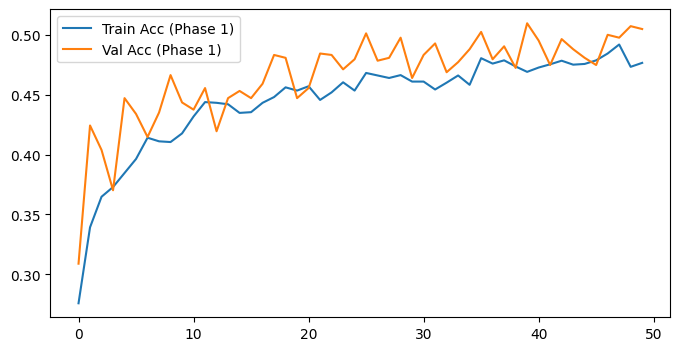

In [16]:
history1 = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)
plt.figure(figsize=(8,4))
plt.plot(history1.history["accuracy"], label="Train Acc (Phase 1)")
plt.plot(history1.history["val_accuracy"], label="Val Acc (Phase 1)")
plt.legend()
plt.show()


## fine tune model ##

Epoch 1/20


2025-04-26 15:39:52.494743: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,256,45,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,45,45]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-26 15:39:52.679792: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.884442853s
Trying algorithm eng0{} for conv (f32[32,256,45,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,45,45]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_c

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3120 - loss: 1.4941
Epoch 1: val_loss improved from inf to 1.38697, saving model to best_model_phase2.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.3123 - loss: 1.4932 - val_accuracy: 0.2668 - val_loss: 1.3870 - learning_rate: 1.0000e-05
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.3967 - loss: 1.2931
Epoch 2: val_loss improved from 1.38697 to 1.17867, saving model to best_model_phase2.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 96s 914ms/step - accuracy: 0.3969 - loss: 1.2927 - val_accuracy: 0.4615 - val_loss: 1.1787 - learning_rate: 1.0000e-05
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.4376 - loss: 1.2115
Epoch 3: val_loss improved from 1.17867 to 1.15716, saving model to best_model_phase2.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 102s 980ms/step - accuracy: 0.4377 - loss: 1.2114 - val_accuracy: 0.4832 - val_loss: 1.1572 - learning_rate: 1.0000e-05
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.4636 - loss: 1.2020
Epoch 4: val_loss improved from 1.15716 to 1.05780, saving model to best_model_phase2.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4637 - loss: 1.2017 - val_accuracy: 0.5264 - val_loss: 1.0578 - learning_rate: 1.0000e-05
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4679 - loss: 1.1585
Epoch 5: val_loss did not improve from 1.05780
104/104 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.4681 - loss: 1.1584 - val_accuracy: 0.5240 - val_loss: 1.0816 - learning_rate: 1.0000e-05
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4710 - loss: 1.1754
Epoch 6: val_loss did not improve from 1.05780
104/104 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.4712 - loss: 1.1751 - val_accuracy: 0.5373 - val_loss: 1.0642 - learning_rate: 1.0000e-05
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.4984 - loss: 1.1250
Epoch 7: val_loss did not improve from 1.05780

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
104/104 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4982 - loss: 1.1252 - val_accu

104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4990 - loss: 1.1273 - val_accuracy: 0.5709 - val_loss: 0.9873 - learning_rate: 5.0000e-06
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.5243 - loss: 1.0592
Epoch 9: val_loss did not improve from 0.98731
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 769ms/step - accuracy: 0.5242 - loss: 1.0592 - val_accuracy: 0.4411 - val_loss: 1.1800 - learning_rate: 5.0000e-06
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5044 - loss: 1.0870
Epoch 10: val_loss did not improve from 0.98731
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 747ms/step - accuracy: 0.5046 - loss: 1.0869 - val_accuracy: 0.5156 - val_loss: 1.0528 - learning_rate: 5.0000e-06
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5467 - loss: 1.0129
Epoch 11: val_loss improved from 0.98731 to 0.97202, saving model to best_model_phase2.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 806ms/step - accuracy: 0.5467 - loss: 1.0130 - val_accuracy: 0.5577 - val_loss: 0.9720 - learning_rate: 5.0000e-06
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.5493 - loss: 1.0180
Epoch 12: val_loss improved from 0.97202 to 0.96452, saving model to best_model_phase2.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 766ms/step - accuracy: 0.5492 - loss: 1.0179 - val_accuracy: 0.5745 - val_loss: 0.9645 - learning_rate: 5.0000e-06
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.5480 - loss: 1.0459
Epoch 13: val_loss did not improve from 0.96452
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 776ms/step - accuracy: 0.5479 - loss: 1.0459 - val_accuracy: 0.5168 - val_loss: 1.0649 - learning_rate: 5.0000e-06
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.5437 - loss: 1.0371
Epoch 14: val_loss did not improve from 0.96452
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 731ms/step - accuracy: 0.5438 - loss: 1.0370 - val_accuracy: 0.5493 - val_loss: 0.9860 - learning_rate: 5.0000e-06
Epoch 15/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.5295 - loss: 1.0462
Epoch 15: val_loss did not improve from 0.96452

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 749ms/step - accuracy: 0.5293 - lo

104/104 ━━━━━━━━━━━━━━━━━━━━ 88s 840ms/step - accuracy: 0.5525 - loss: 0.9920 - val_accuracy: 0.5709 - val_loss: 0.9522 - learning_rate: 2.5000e-06
Epoch 17/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5694 - loss: 0.9729
Epoch 17: val_loss did not improve from 0.95225
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 785ms/step - accuracy: 0.5694 - loss: 0.9729 - val_accuracy: 0.5649 - val_loss: 0.9552 - learning_rate: 2.5000e-06
Epoch 18/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.5827 - loss: 0.9677
Epoch 18: val_loss improved from 0.95225 to 0.93361, saving model to best_model_phase2.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 763ms/step - accuracy: 0.5827 - loss: 0.9678 - val_accuracy: 0.5853 - val_loss: 0.9336 - learning_rate: 2.5000e-06
Epoch 19/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.5842 - loss: 0.9694
Epoch 19: val_loss did not improve from 0.93361
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 780ms/step - accuracy: 0.5841 - loss: 0.9694 - val_accuracy: 0.5709 - val_loss: 0.9650 - learning_rate: 2.5000e-06
Epoch 20/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.5857 - loss: 0.9669
Epoch 20: val_loss did not improve from 0.93361
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 753ms/step - accuracy: 0.5857 - loss: 0.9669 - val_accuracy: 0.5805 - val_loss: 0.9421 - learning_rate: 2.5000e-06
Restoring model weights from the end of the best epoch: 18.


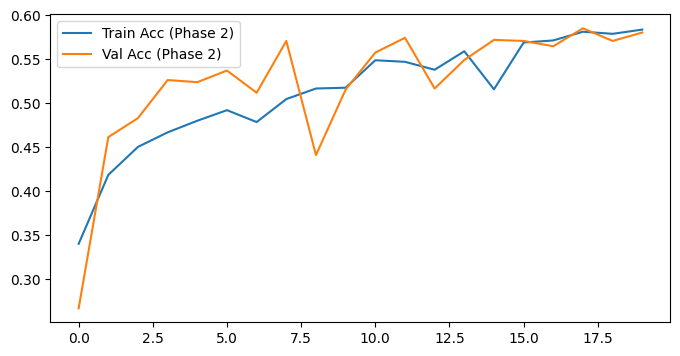

In [17]:
conv_base.trainable = True
for layer in conv_base.layers[:-15]:
    layer.trainable = False

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  
    metrics=["accuracy"]
)


checkpoint_phase2 = ModelCheckpoint(
    'best_model_phase2.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history2 = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint_phase2,reduce_lr],
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history2.history["accuracy"], label="Train Acc (Phase 2)")
plt.plot(history2.history["val_accuracy"], label="Val Acc (Phase 2)")
plt.legend()
plt.show()

In [18]:
print("=== Evaluate on val_dataset ===")
val_loss, val_acc = model.evaluate(val_dataset, verbose=1)
print(f"Final Validation Loss = {val_loss:.4f}")
print(f"Final Validation Acc  = {val_acc:.4f}")

=== Evaluate on val_dataset ===
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 613ms/step - accuracy: 0.5852 - loss: 0.9353
Final Validation Loss = 0.9336
Final Validation Acc  = 0.5853


In [19]:
model.save("vgg16_model.h5")
print("Model saved to vgg16_model.h5")

Model saved to vgg16_model.h5


In [32]:
model.save("vgg16_model.keras")


#  K-Fold Cross Validation

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay



In [23]:
def build_vgg16_model():
    conv_base = keras.applications.vgg16.VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(128, 180, 3)   # Điều chỉnh đúng shape dữ liệu
    )
    conv_base.trainable = False  # Phase 1: Freeze

    inputs = keras.Input(shape=(128, 180, 3))
    x = keras.applications.vgg16.preprocess_input(inputs)
    x = conv_base(x, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model, conv_base


In [24]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracies = []
fold_idx = 1

for train_idx, val_idx in skf.split(combined_df['Path'], combined_df['Label']):
    print(f"\n===== Fold {fold_idx}/{k_folds} =====")

    train_df = combined_df.iloc[train_idx]
    val_df   = combined_df.iloc[val_idx]

    # Tạo Dataset
    train_dataset = SpectrogramDataset(train_df['Path'], train_df['Label'], batch_size=32, shuffle=True)
    val_dataset   = SpectrogramDataset(val_df['Path'], val_df['Label'], batch_size=32, shuffle=False)

    # Build model & conv_base
    model, conv_base = build_vgg16_model()

    # Callbacks
    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=0)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)

    # === Phase 1: Freeze Training ===
    model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stop, reduce_lr], verbose=0)

    # === Phase 2: Fine-tune ===
    conv_base.trainable = True
    for layer in conv_base.layers[:-10]:
        layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stop, reduce_lr], verbose=0)

    # Đánh giá
    val_loss, val_acc = model.evaluate(val_dataset, verbose=0)
    print(f"Fold {fold_idx} - Final Validation Accuracy: {val_acc:.4f}")

    accuracies.append(val_acc)
    fold_idx += 1



===== Fold 1/5 =====


/mnt/d/1203_ISEmotalk/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-26 16:22:20.875544: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.533835971s
Trying algorithm eng15{k5=1,k6=0,k7=1,k10=4} for conv (f32[32,256,32,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,32,45]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_op

✅ Fold 1 - Final Validation Accuracy: 0.5300

===== Fold 2/5 =====
✅ Fold 2 - Final Validation Accuracy: 0.5709

===== Fold 3/5 =====
✅ Fold 3 - Final Validation Accuracy: 0.5349

===== Fold 4/5 =====
✅ Fold 4 - Final Validation Accuracy: 0.5637

===== Fold 5/5 =====
✅ Fold 5 - Final Validation Accuracy: 0.5337


In [25]:
mean_acc = np.mean(accuracies)
std_acc  = np.std(accuracies)

print(f"\n=== K-Fold Cross Validation ({k_folds} folds) ===")
print(f"Mean Final Accuracy : {mean_acc:.4f}")
print(f"Standard Deviation  : {std_acc:.4f}")



=== K-Fold Cross Validation (5 folds) ===
Mean Final Accuracy : 0.5466
Standard Deviation  : 0.0171


# Evalution 

In [29]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [30]:
# Giả sử đã load combined_df từ trước
from sklearn.model_selection import train_test_split

# Chia lại tập validation (nếu chưa có sẵn val_df)
train_df, val_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['Label'], random_state=42)

# Tạo lại Dataset cho validation
val_dataset = SpectrogramDataset(val_df['Path'], val_df['Label'], batch_size=32, shuffle=False)


In [ ]:

model = load_model("vgg16_model.keras")


In [ ]:
val_loss, val_acc = model.evaluate(val_dataset, verbose=1)
print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Validation Loss      : {val_loss:.4f}")


/mnt/d/1203_ISEmotalk/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 911ms/step - accuracy: 0.5413 - loss: 1.1591

🎯 Validation Accuracy: 0.5385
Validation Loss      : 1.1502



Classification Report:
              precision    recall  f1-score   support

       angry       0.71      0.65      0.68       220
       happy       0.42      0.53      0.47       219
     neutral       0.39      0.41      0.40       174
         sad       0.67      0.54      0.60       219

    accuracy                           0.54       832
   macro avg       0.55      0.53      0.54       832
weighted avg       0.56      0.54      0.54       832



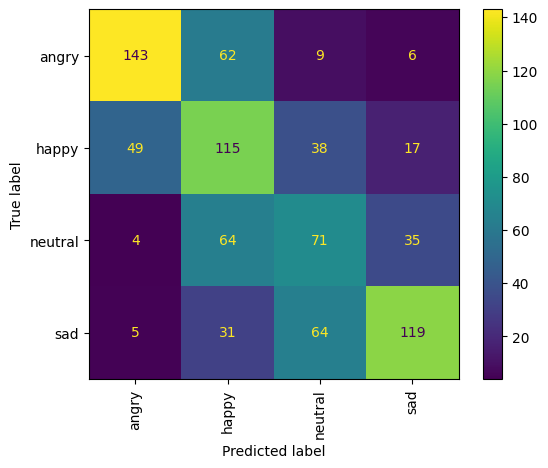

In [36]:
all_preds = []
all_labels = []

for idx in range(len(val_dataset)):
    try:
        X_batch, y_batch = val_dataset[idx]
        preds = model.predict(X_batch, verbose=0)
        all_preds.extend(np.argmax(preds, axis=1))
        all_labels.extend(y_batch.tolist())
    except RuntimeError as e:
        print(f"Bỏ qua batch lỗi: {e}")
        continue

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_).plot(xticks_rotation='vertical')
plt.show()
